In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pandas as pd
# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('data/composite_wheel_guard.stl',remove_duplicate_polygons=1,calculate_normals=False,)
import numpy as np

In [2]:
import operator
normals=pd.DataFrame(your_mesh.normals)
values,counts=np.unique(normals[2], return_counts=True)
max(enumerate(counts), key=operator.itemgetter(1))

(18807, 2)

In [3]:
your_mesh.points[0]

array([0.4027413 , 0.00314976, 0.1673314 , 0.3908333 , 0.00332636,
       0.1676275 , 0.3959583 , 0.00321191, 0.1629661 ], dtype=float32)

In [4]:
idx=0
U=your_mesh.v1[idx]-your_mesh.v0[idx]
V=your_mesh.v2[idx]-your_mesh.v0[idx]

np.cross(V,U)

array([ 7.8929571e-07,  5.3990498e-05, -4.5779120e-07], dtype=float32)

In [5]:
pt1=np.array([1.881639e+01,1.613502e+01,2.185584e+01])
pt2=np.array([1.875863e+01,1.610805e+01,2.286690e+01])
pt3=np.array([1.878258e+01,1.611923e+01,2.185014e+01])

In [6]:
your_mesh.v0[0]

array([0.4027413 , 0.00314976, 0.1673314 ], dtype=float32)

In [7]:
U=pt2-pt1
V=pt3-pt1
np.cross(V,U)

array([-1.61183664e-02,  3.45131706e-02, -1.74700000e-07])

In [8]:
toplayer_points=pd.DataFrame(your_mesh.points[normals[normals[2]>=0].index])
toplayer_points[toplayer_points.eq(40.784870).any(axis=1) & toplayer_points.eq(41.287041).any(axis=1) & toplayer_points.eq(41.347549).any(axis=1) ]

,0,1,2,3,4,5,6,7,8


In [9]:
toplayer_v0=pd.DataFrame(your_mesh.v0[normals[normals[2]>0].index])
toplayer_v1=pd.DataFrame(your_mesh.v1[normals[normals[2]>0].index])
toplayer_v2=pd.DataFrame(your_mesh.v2[normals[normals[2]>0].index])
toplayer=pd.concat([toplayer_v0,toplayer_v1,toplayer_v2])

In [10]:
toplayer=toplayer.drop_duplicates()
toplayer=toplayer.dropna()
toplayer.shape

(6260, 3)

In [11]:
toplayer.dtypes

0    float32
1    float32
2    float32
dtype: object

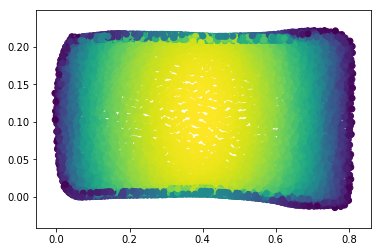

In [12]:
import matplotlib.pyplot as plt
plt.scatter(toplayer[0], toplayer[1], c=toplayer[2])
plt.show()

In [13]:
idx=300
selected_points=toplayer[:idx]

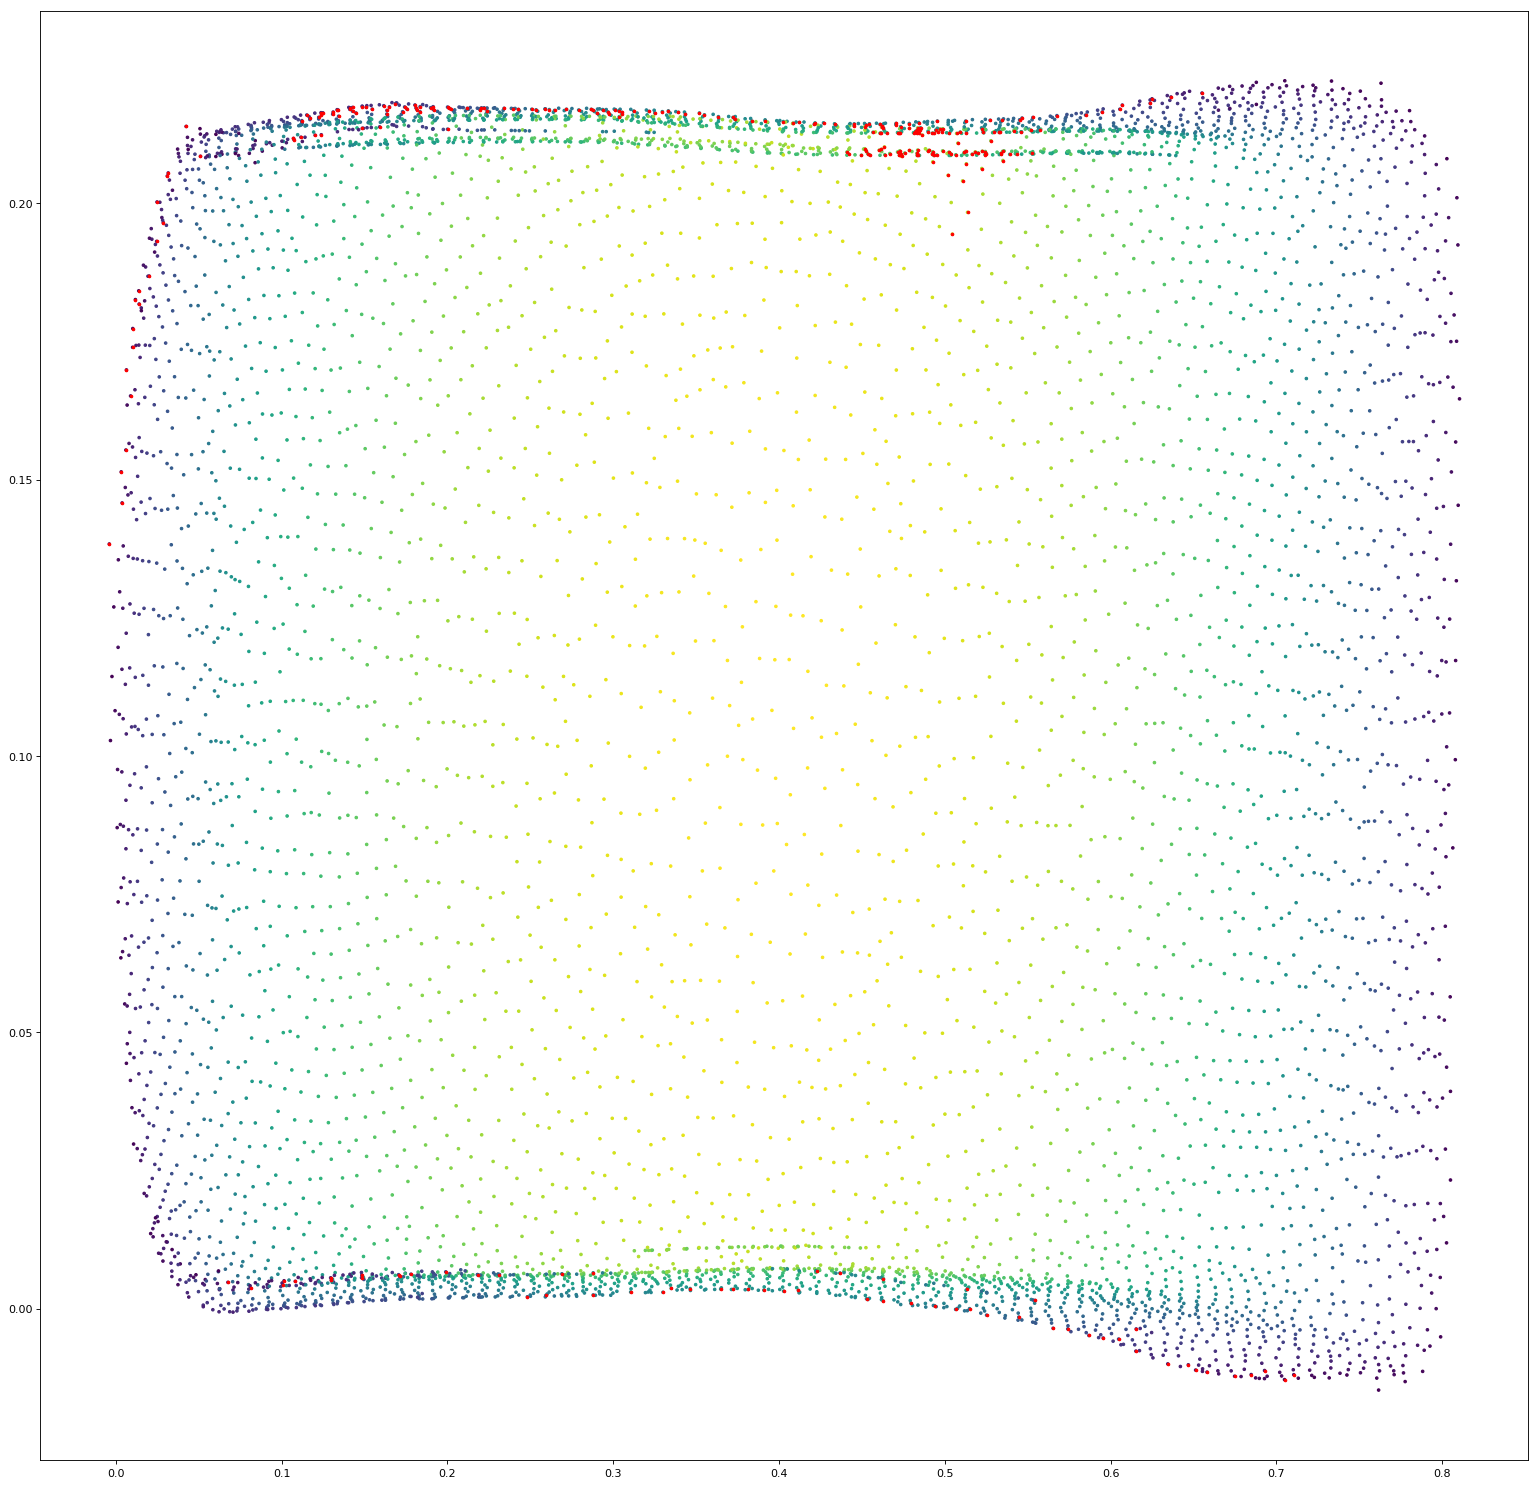

In [14]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 24), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(toplayer[0], toplayer[1], c=toplayer[2],s=5)
plt.scatter(selected_points[0], selected_points[1], c="red",s=5)

plt.show()

In [15]:
from operator import itemgetter
from collections import defaultdict

from copy import copy

def point_to_hashmap(vector):
    data_dict = defaultdict(list)
    a,b=zip(*sorted(enumerate(vector[:,0]), key=itemgetter(1)))
    for idx,coordinate in zip(a,b):
        data_dict[coordinate].append(idx)
    return data_dict



def get_adj_polygons(selected_polygons):
    v0_hashmap=point_to_hashmap(selected_polygons[:,0:3])
    v1_hashmap=point_to_hashmap(selected_polygons[:,3:6])
    v2_hashmap=point_to_hashmap(selected_polygons[:,6:9])
    #adj_polygons=defaultdict(lambda: defaultdict(list))
    adj_polygons=defaultdict(list)

    for v in v0_hashmap:
        for c0 in v0_hashmap[v]:

            for c00 in v0_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c00,0:3]
                v1_b=selected_polygons[c00,3:6]
                v2_b=selected_polygons[c00,6:9]
                if list(v0_a)==list(v0_b) and c0!=c00:
                    if( (list(v1_a)==list(v1_b) or list(v1_a)==list(v2_b)) or 
                            (list(v2_a)==list(v1_b) or list(v2_a)==list(v2_b))):
                        if c0 not in adj_polygons[c00] or c00 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c00)
                            adj_polygons[c00].append(c0)        
            for c1 in v1_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c1,0:3]
                v1_b=selected_polygons[c1,3:6]
                v2_b=selected_polygons[c1,6:9]
                if list(v0_a)==list(v1_b): 
                    if((list(v1_a)==list(v0_b) or list(v1_a)==list(v2_b))) or  (list(v2_a)==list(v0_b) or list(v2_a)==list(v2_b)):
                        if c0 not in adj_polygons[c1] or c1 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c1)
                            adj_polygons[c1].append(c0)                  
            for c2 in v2_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c2,0:3]
                v1_b=selected_polygons[c2,3:6]
                v2_b=selected_polygons[c2,6:9]
                if list(v0_a)==list(v2_b): # and c0!=c2:  
                    if(list(v1_a)==list(v0_b) or list(v1_a)==list(v1_b)) or (list(v2_a)==list(v0_b) or list(v2_a)==list(v1_b)):
                        if c0 not in adj_polygons[c2] or c2 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c2)
                            adj_polygons[c2].append(c0)

        
    return adj_polygons


def get_connected_region(selected_polygons):

    adj_polygons=get_adj_polygons(selected_polygons)
    polygons=copy(adj_polygons)
    connected_regions=defaultdict(list)
    key_idx=0
    max_idx=len(selected_polygons)
    visited=[False]*max_idx
    while(key_idx<max_idx):
        stack_v1=[]
        stack_v1+=adj_polygons[key_idx]
        adj_polygons[key_idx]=[]
        # Tree traversal v1
        while len(stack_v1)>0:
            node=stack_v1.pop(0)
            if key_idx==node or len(adj_polygons[node])==0:
                continue
            
            for adj_node in adj_polygons[node]:
                if(not visited[adj_node]):
                    connected_regions[key_idx]+=[adj_node]
                    stack_v1+=[adj_node]
                    visited[adj_node]=True


            adj_polygons[node]=[]
        key_idx+=1
    return connected_regions


## Find disjoint areas

2 polygons must share an edge to be joined. To share an edge they must share two vertices

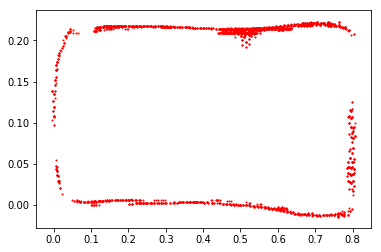

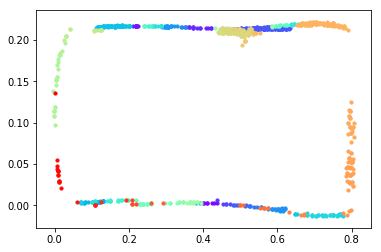

In [16]:
toplayer_polygons=pd.DataFrame(your_mesh.points[normals[normals[2]>0].index])
selected_polygons=np.array(toplayer_polygons)[:1000]
_df=pd.DataFrame(selected_polygons, index=None)
plt.scatter(_df[0], _df[1], c="red", s=1)
plt.scatter(_df[3], _df[4], c="red", s=1)
plt.scatter(_df[6], _df[7], c="red", s=1)

import matplotlib.cm as cm

a=get_connected_region(selected_polygons)
plt.show()
colors = iter(cm.rainbow(np.linspace(0, 1, len(a.keys()))))
for idx in a:
    idxs=a[idx]
    color2=next(colors)
    if(idx==0):
        continue
    plt.scatter(selected_polygons[idxs][:,0], selected_polygons[idxs][:,1], c=[color2], s=10)

plt.show()

In [17]:
"""
def point_to_hashmap(vector):
    data_dict = defaultdict(list)
    a,b=zip(*sorted(enumerate(vector[:,0]), key=itemgetter(1)))
    for idx,coordinate in zip(a,b):
        data_dict[coordinate].append(idx)
    return data_dict
"""
print(a.keys())
#v0_hashmap=point_to_hashmap(connected_region[:,0:3])
#v1_hashmap=point_to_hashmap(connected_region[:,3:6])
#v2_hashmap=point_to_hashmap(connected_region[:,6:9])

dict_keys([1, 2, 4, 5, 6, 9, 10, 13, 18, 20, 28, 33, 34, 37, 39, 43, 47, 48, 49, 50, 55, 60, 63, 64, 67, 74, 78, 79, 82, 85, 87, 89, 90, 91, 93, 95, 104, 105, 107, 108, 109, 111, 112, 114, 126, 128, 135, 271, 279, 305, 347, 363, 385, 405, 425, 636, 737, 763, 804, 814, 840, 847, 869, 881, 915, 918, 932, 936, 939, 949, 951, 973, 975, 998])


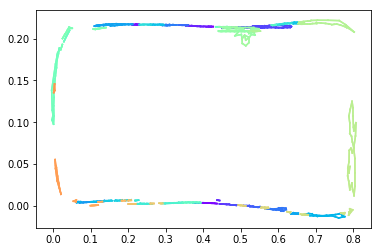

In [18]:
colors = iter(cm.rainbow(np.linspace(0, .8, len(a.keys()))))

for region in a:
    connected_region=selected_polygons[a[region]]
    #print(len(connected_region))
    x1=(connected_region[:,0]).flatten()
    y1=(connected_region[:,1]).flatten()
    x2=(connected_region[:,3]).flatten()
    y2=(connected_region[:,4]).flatten()
    x3=(connected_region[:,6]).flatten()
    y3=(connected_region[:,7]).flatten()
    line_segments=[]
    
    _color=next(colors)
    for _idx1,_x1 in enumerate(x1):
        line_segments.append([[x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]]])
        line_segments.append([[x2[_idx1],x1[_idx1]],[y2[_idx1],y1[_idx1]]])
        line_segments.append([[x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]]])
        line_segments.append([[x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]]])
        line_segments.append([[x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]]])
        line_segments.append([[x1[_idx1],x3[_idx1]],[y1[_idx1],y3[_idx1]]])

        #plt.plot([x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]],'r-')
        #plt.plot([x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]],'r-')
        #plt.plot([x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]],'r-')
        #plt.plot([x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]],'r-')
    _v,_c=np.unique(np.array(line_segments),return_counts=True,axis=0)
    #plt.show()
    unique_lines=_v[np.where(_c < 2)[0]]
    #print(len(unique_lines))
    for _l in unique_lines:
        plt.plot(list(_l[0]),list(_l[1]),'r-',c=_color)

    
#idxs=sorted(uniques)
#x=(connected_region[idxs][:,0]).flatten()
#y=(connected_region[idxs][:,1]).flatten()
#plt.plot(x,y, 'b.', lw=2)

In [19]:
len(np.where(_c < 2)[0])

6

2
[[[0.4004426  0.00345173]
  [0.3936593  0.00346703]]

 [[0.4027413  0.00314976]
  [0.4124526  0.00294646]]

 [[0.4227568  0.00275072]
  [0.4227887  0.00302938]]

 [[0.4117189  0.00327672]
  [0.4004426  0.00345173]]

 [[0.4117189  0.00327672]
  [0.4124526  0.00294646]]

 [[0.4304054  0.00277938]
  [0.4227887  0.00302938]]

 [[0.4366259  0.00242311]
  [0.4304054  0.00277938]]

 [[0.3936593  0.00346703]
  [0.4004426  0.00345173]]

 [[0.4124526  0.00294646]
  [0.4027413  0.00314976]]

 [[0.4227887  0.00302938]
  [0.4227568  0.00275072]]

 [[0.4004426  0.00345173]
  [0.4117189  0.00327672]]

 [[0.4124526  0.00294646]
  [0.4117189  0.00327672]]

 [[0.4227887  0.00302938]
  [0.4304054  0.00277938]]

 [[0.4304054  0.00277938]
  [0.4366259  0.00242311]]]
[[[0.3936593  0.00346703]
  [0.4004426  0.00345173]]

 [[0.3936593  0.00346703]
  [0.4027413  0.00314976]]

 [[0.4004426  0.00345173]
  [0.3936593  0.00346703]]

 [[0.4004426  0.00345173]
  [0.4117189  0.00327672]]

 [[0.4027413  0.00314976]


39
[[[ 0.5741125  -0.00368752]
  [ 0.5652867  -0.00357272]]

 [[ 0.585264   -0.00436936]
  [ 0.5806078  -0.00375718]]

 [[ 0.5760339  -0.0041908 ]
  [ 0.5806078  -0.00375718]]

 [[ 0.5868669  -0.00488201]
  [ 0.585264   -0.00436936]]

 [[ 0.5868669  -0.00488201]
  [ 0.5940455  -0.00475218]]

 [[ 0.5955284  -0.00534077]
  [ 0.5940455  -0.00475218]]

 [[ 0.5940455  -0.00475218]
  [ 0.5908547  -0.00390582]]

 [[ 0.5940455  -0.00475218]
  [ 0.6005118  -0.00454026]]

 [[ 0.6005118  -0.00454026]
  [ 0.5940455  -0.00475218]]

 [[ 0.6005118  -0.00454026]
  [ 0.5992872  -0.00358004]]

 [[ 0.610386   -0.00487922]
  [ 0.6005118  -0.00454026]]

 [[ 0.6005118  -0.00454026]
  [ 0.6092643  -0.00377263]]

 [[ 0.6047978  -0.0055303 ]
  [ 0.6131116  -0.0056733 ]]

 [[ 0.6092643  -0.00377263]
  [ 0.6016885  -0.00283852]]

 [[ 0.6145386  -0.00656399]
  [ 0.6131116  -0.0056733 ]]

 [[ 0.6131116  -0.0056733 ]
  [ 0.6217487  -0.00476466]]

 [[ 0.6115994  -0.00260489]
  [ 0.6016885  -0.00283852]]

 [[ 0.60770

64
[[[ 0.6928276  -0.01122186]
  [ 0.684764   -0.01195497]]

 [[ 0.7031285  -0.01220321]
  [ 0.7019796  -0.01154522]]

 [[ 0.6928276  -0.01122186]
  [ 0.6911765  -0.0099    ]]

 [[ 0.6943812  -0.01225332]
  [ 0.7019796  -0.01154522]]

 [[ 0.7104474  -0.01197573]
  [ 0.7019796  -0.01154522]]

 [[ 0.6805966  -0.01099606]
  [ 0.684764   -0.01195497]]

 [[ 0.6805966  -0.01099606]
  [ 0.6911765  -0.0099    ]]

 [[ 0.7031285  -0.01220321]
  [ 0.704881   -0.01286279]]

 [[ 0.6812007  -0.00949472]
  [ 0.6707739  -0.01023754]]

 [[ 0.7104474  -0.01197573]
  [ 0.704881   -0.01286279]]

 [[ 0.721307   -0.01210057]
  [ 0.7104474  -0.01197573]]

 [[ 0.7228566  -0.01245559]
  [ 0.721307   -0.01210057]]

 [[ 0.721307   -0.01210057]
  [ 0.7228566  -0.01245559]]

 [[ 0.7290867  -0.01170097]
  [ 0.721307   -0.01210057]]

 [[ 0.7318196  -0.01255499]
  [ 0.7383337  -0.01171076]]

 [[ 0.7425101  -0.01203294]
  [ 0.7383337  -0.01171076]]

 [[ 0.7506866  -0.01163154]
  [ 0.7383337  -0.01171076]]

 [[ 0.75068

109
[[[0.3725024  0.00347029]
  [0.3652048  0.00373746]]

 [[0.3652048  0.00373746]
  [0.3528576  0.00387823]]

 [[0.3747709  0.00364301]
  [0.3736971  0.00403884]]

 [[0.3558205  0.00348785]
  [0.3528576  0.00387823]]

 [[0.3652048  0.00373746]
  [0.3609703  0.00430252]]

 [[0.3647802  0.00351858]
  [0.3652048  0.00373746]]

 [[0.3652048  0.00373746]
  [0.3725024  0.00347029]]

 [[0.3652048  0.00373746]
  [0.3736971  0.00403884]]

 [[0.3736971  0.00403884]
  [0.3747709  0.00364301]]

 [[0.3837656  0.00361823]
  [0.3821336  0.00403512]]

 [[0.3837656  0.00361823]
  [0.3910488  0.00390616]]

 [[0.3936593  0.00346703]
  [0.3910488  0.00390616]]

 [[0.3652048  0.00373746]
  [0.3725024  0.00347029]]

 [[0.3528576  0.00387823]
  [0.3652048  0.00373746]]

 [[0.3736971  0.00403884]
  [0.3747709  0.00364301]]

 [[0.3528576  0.00387823]
  [0.3558205  0.00348785]]

 [[0.3609703  0.00430252]
  [0.3652048  0.00373746]]

 [[0.3652048  0.00373746]
  [0.3647802  0.00351858]]

 [[0.3725024  0.00347029

347
[[[0.4968675 0.2134319]
  [0.5070781 0.2126371]]

 [[0.4968675 0.2134319]
  [0.4986687 0.2134836]]

 [[0.4986687 0.2134836]
  [0.511499  0.2133658]]

 [[0.4968675 0.2134319]
  [0.511499  0.2133658]]

 [[0.4960298 0.2129055]
  [0.5070781 0.2126371]]

 [[0.4968675 0.2134319]
  [0.4905054 0.2135895]]

 [[0.4848911 0.2131814]
  [0.4960298 0.2129055]]

 [[0.5070781 0.2126371]
  [0.4960298 0.2129055]]

 [[0.4786624 0.2135482]
  [0.4848911 0.2131814]]

 [[0.4848911 0.2131814]
  [0.4864871 0.2123194]]

 [[0.4848911 0.2131814]
  [0.4786624 0.2135482]]

 [[0.4848911 0.2131814]
  [0.4729196 0.2126549]]

 [[0.4786624 0.2135482]
  [0.4618147 0.2137565]]

 [[0.4729196 0.2126549]
  [0.463583  0.2101882]]

 [[0.4618147 0.2137565]
  [0.4517722 0.2132251]]

 [[0.463583  0.2101882]
  [0.4883099 0.2098556]]

 [[0.4517147 0.2138693]
  [0.4517722 0.2132251]]

 [[0.4729196 0.2126549]
  [0.4517722 0.2132251]]

 [[0.4864871 0.2123194]
  [0.4883099 0.2098556]]

 [[0.5078505 0.2108774]
  [0.4883099 0.2098556

763
[[[0.8019122  0.0288465 ]
  [0.80497    0.02325149]]

 [[0.8001817  0.03807677]
  [0.8019122  0.0288465 ]]

 [[0.8049697  0.03929252]
  [0.80479    0.05639645]]

 [[0.8019122  0.0288465 ]
  [0.7988517  0.01899178]]

 [[0.80497    0.02325149]
  [0.8008489  0.01665798]]

 [[0.8012524  0.05219001]
  [0.8001817  0.03807677]]

 [[0.796761   0.02710576]
  [0.8019122  0.0288465 ]]

 [[0.8026361  0.04367075]
  [0.8019122  0.0288465 ]]

 [[0.80479    0.05639645]
  [0.8012524  0.05219001]]

 [[0.80497    0.02325149]
  [0.8019122  0.0288465 ]]

 [[0.796761   0.02710576]
  [0.7988517  0.01899178]]

 [[0.8012524  0.05219001]
  [0.7984684  0.04604222]]

 [[0.7968506  0.03647108]
  [0.796761   0.02710576]]

 [[0.8012524  0.05219001]
  [0.80479    0.05639645]]

 [[0.798027   0.0527246 ]
  [0.7984684  0.04604222]]

 [[0.7968506  0.03647108]
  [0.7930697  0.02857766]]

 [[0.7968506  0.03647108]
  [0.8001817  0.03807677]]

 [[0.7980965  0.06310737]
  [0.8012524  0.05219001]]

 [[0.798027   0.0527246 

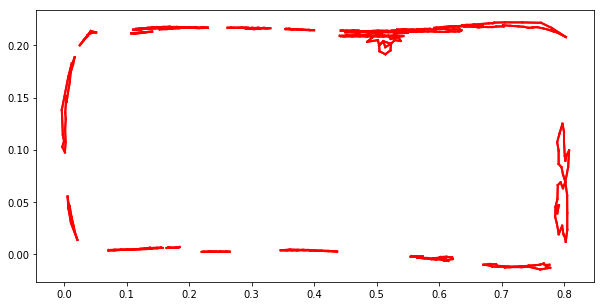

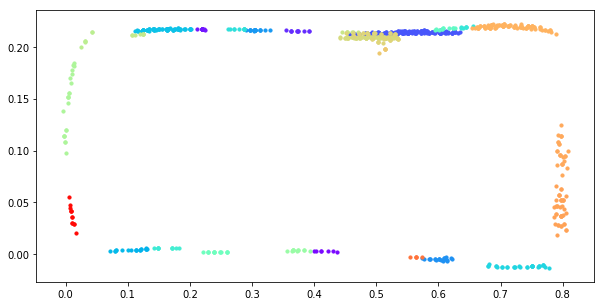

In [20]:
import matplotlib.cm as cm
import itertools
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

for idx in a:
    idxs=a[idx]
    if(len(idxs)<5):
        continue
    print(idx)
    region=selected_polygons[idxs][:,0:2]
    x=(selected_polygons[idxs][:,0]).flatten()
    y=(selected_polygons[idxs][:,1]).flatten()
    v0=np.array(list(zip(x,y)))
    x=(selected_polygons[idxs][:,3]).flatten()
    y=(selected_polygons[idxs][:,4]).flatten()
    v1=np.array(list(zip(x,y)))
    x=(selected_polygons[idxs][:,6]).flatten()
    y=(selected_polygons[idxs][:,7]).flatten()
    v2=np.array(list(zip(x,y)))
    edge1=np.concatenate((np.array(list(zip(v0,v1))),np.array(list(zip(v1,v0)))))
    print(edge1)
    edge2=np.concatenate((np.array(list(zip(v1,v2))),np.array(list(zip(v2,v1)))))
    edge3=np.concatenate((np.array(list(zip(v0,v2))),np.array(list(zip(v2,v0)))))
    edges=np.concatenate((edge1,edge2,edge3))
    uniques=np.unique(edges, return_counts=True,axis=0)
    border=uniques[0][np.where(uniques[1]==1)]
    print(border)
    #last_edge=np.concatenate(([border[0,0,:]],[border[-1,0,:]]))
    #border=np.concatenate((border,[last_edge]))
    ordered_edges=[]
    for edge in border:
        ordered_edges.append(list(edge[0,:]))
        for edge2 in border:
            if list(edge[0,:]) == list(edge2[1,:]) and  list(edge[1,:]) == list(edge2[0,:]):                
                #print(edge)
                #print(edge2)
                #print("-----")
                ordered_edges.append(list(edge2[1,:]))
        
        x=edge[:,0]
        y=edge[:,1]
        plt.plot(x,y, 'r-', lw=2)
    #print(ordered_edges)
plt.show()
colors = iter(cm.rainbow(np.linspace(0, 1, len(a.keys()))))
for idx in a:
    idxs=a[idx]
    color2=next(colors)
    if(len(idxs)<5):
        continue
    plt.scatter(selected_polygons[idxs][:,0], selected_polygons[idxs][:,1], c=[color2], s=10)
    
np.meshgrid(np.linspace(-5, 5, 5),np.linspace(-12, -3, 3))
plt.show()

In [21]:
np.mgrid[0:5,0:5,0:5]

array([[[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]],

        [[2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2]],

        [[3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3]],

        [[4, 4, 4, 4, 4],
         [4, 4, 4, 4, 4],
         [4, 4, 4, 4, 4],
         [4, 4, 4, 4, 4],
         [4, 4, 4, 4, 4]]],


       [[[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]],

        [[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]],

        [[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 

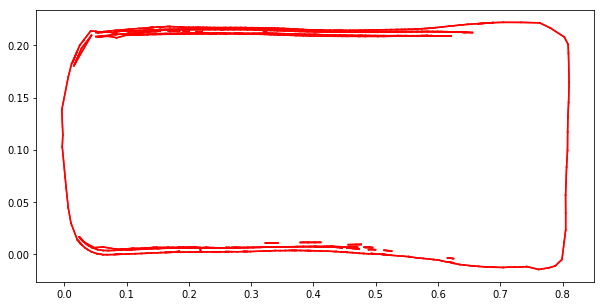

In [22]:
toplayer_polygons=pd.DataFrame(your_mesh.points[normals[normals[2]>0.01].index])
selected_polygons=np.array(toplayer_polygons)


colors = iter(cm.rainbow(np.linspace(0, .8, len(a.keys()))))

connected_region=selected_polygons
#print(len(connected_region))
x1=(connected_region[:,0]).flatten()
y1=(connected_region[:,1]).flatten()
x2=(connected_region[:,3]).flatten()
y2=(connected_region[:,4]).flatten()
x3=(connected_region[:,6]).flatten()
y3=(connected_region[:,7]).flatten()
line_segments=[]

_color=next(colors)
for _idx1,_x1 in enumerate(x1):
    line_segments.append([[x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]]])
    line_segments.append([[x2[_idx1],x1[_idx1]],[y2[_idx1],y1[_idx1]]])
    line_segments.append([[x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]]])
    line_segments.append([[x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]]])
    line_segments.append([[x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]]])
    line_segments.append([[x1[_idx1],x3[_idx1]],[y1[_idx1],y3[_idx1]]])

    #plt.plot([x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]],'r-')
    #plt.plot([x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]],'r-')
    #plt.plot([x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]],'r-')
    #plt.plot([x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]],'r-')
_v,_c=np.unique(np.array(line_segments),return_counts=True,axis=0)
#plt.show()
unique_lines=_v[np.where(_c < 2)[0]]
#print(len(unique_lines))
for _l in unique_lines:
    plt.plot(list(_l[0]),list(_l[1]),'r-')
x_stack=np.dstack((x1,x2,x3))
y_stack=np.dstack((y1,y2,y3))
x_max=np.max(x_stack)
y_max=np.max(y_stack)
x_min=np.min(x_stack)
y_min=np.min(y_stack)
dx=3
num_x=(x_max-x_min)//dx
for x in np.linspace(x_min, x_max,num_x):
    y=np.linspace(y_min, y_max)
    plt.plot([x]*len(y),y,'b.')

In [23]:
normals=pd.DataFrame(your_mesh.normals)
toplayer_polygons=pd.DataFrame(your_mesh.points[normals[normals[2]>0.01].index])
selected_polygons=np.array(toplayer_polygons)

def area(x1, y1, x2, y2, x3, y3): 
  
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                + x3 * (y1 - y2)) / 2.0) 
  
    
def isInside(x1, y1, x2, y2, x3, y3, x, y): 
    

    Area = 0.5 *(-y2*x3 + y1*(-x2 + x3) + x1*(y2 - y3) + x2*y3);
    s = 1/(2*Area)*(y1*x3 - x1*y3 + (y3 - y1)*x + (x1 - x3)*y);
    t = 1/(2*Area)*(x1*y2 - y1*x2 + (y1 - y2)*x + (x2 - x1)*y);
    if(s>=0 and t>=0 and (1-s-t)>=0):
        return True
    else:
        return False
    
    
def sign (x1, y1, x2, y2, x3, y3):
    return (x1- x3) * (y2 - y3) - (x2 - x3) * (y1 - y3);


def PointInTriangle (x1, y1, x2, y2, x3, y3, x, y): 


    d1 = sign(x,y, x1,y1,x2,y3);
    d2 = sign(x,y, x2,y2, x3,y3);
    d3 = sign(x,y, x3,y3, x1,y1);

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0);
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0);

    return not(has_neg and has_pos);
def pda(x,y,t):
    return sum(a*y+c*b+d*x<d*a+c*y+b*x for i in(0,1,2)for a,b,c,d in[t[i-1]+t[i]])%3<1
def threaded_function(cntr,x,y):
    for idx,_plgn in enumerate(selected_polygons):

        _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=_plgn
        t=((_x1, _y1), (_x2, _y2), (_x3, _y3))
        if pda(x,y,t):
            #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):

            _pt=(x,y,np.mean([_z1,_z2,_z3]),your_mesh.normals[idx])
            point_grid[cntr]=(_pt)
            break#plt.plot(x,y,'b.')
x1=selected_polygons[:,0]
x2=selected_polygons[:,3]
x3=selected_polygons[:,6]
y1=selected_polygons[:,1]
y2=selected_polygons[:,4]
y3=selected_polygons[:,7]
x_max=np.max([np.max(x1),np.max(x2),np.max(x3)])
y_max=np.max([np.max(y1),np.max(y2),np.max(y3)])
x_min=np.max([np.min(x1),np.min(x2),np.min(x3)])
y_min=np.max([np.min(y1),np.min(y2),np.min(y3)])
dx=0.01
num_x=(x_max-x_min)//dx
point_grid=[]#[None]*(int(num_x**2))
cntr=0
threads=[]
from threading import Thread

num_x=42

for x in np.linspace(x_min, x_max,num_x):
    pnt_row=[]
    for y in np.linspace(y_min, y_max,num_x):
        
                #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):
        #thread = Thread(target = threaded_function, args = (cntr,x, y))
        #thread.start()
        #threads.append(thread)
        #cntr+=1;
        _pt=(None,None,None,None)
        
        for idx,_plgn in enumerate(selected_polygons):

            _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=_plgn
            t=((_x1, _y1), (_x2, _y2), (_x3, _y3))
            if isInside(_x1, _y1, _x2, _y2, _x3, _y3, x, y):
                #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):

                _pt=(x,y,np.mean([_z1,_z2,_z3]),your_mesh.normals[idx])
                break#plt.plot(x,y,'b.')
        pnt_row.append(_pt)
    point_grid.append(pnt_row)

KeyboardInterrupt: 

In [ ]:
point_grid=[]
for x in np.linspace(x_min, x_max,num_x):
    pnt_row=[]
    for y in np.linspace(y_min, y_max,num_x):
        
                #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):
        #thread = Thread(target = threaded_function, args = (cntr,x, y))
        #thread.start()
        #threads.append(thread)
        #cntr+=1;
        _pt=(None,None,None,None)
        
        pnt_row.append(_pt)
    point_grid.append(pnt_row)

In [ ]:
def find_enclosing_polygon(x,y):
    for idx,_plgn in enumerate(selected_polygons):

        _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=_plgn
        t=((_x1, _y1), (_x2, _y2), (_x3, _y3))
        if isInside(_x1, _y1, _x2, _y2, _x3, _y3, x, y):
            #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):

            _pt=(x,y,np.mean([_z1,_z2,_z3]),your_mesh.normals[idx])
            break#plt.plot(x,y,'b.')

In [ ]:
np.array(point_grid).shape

In [ ]:
grid=np.array(point_grid)

In [ ]:
grid

## Starting point

In [ ]:
import matplotlib.pyplot as plt
for _l in unique_lines:
    plt.plot(list(_l[0]),list(_l[1]),'r-')
_tmp=grid.reshape(-1,4)[np.where(grid.reshape(-1,4)[:,0]!=None)]
plt.plot(_tmp[:,0],_tmp[:,1],'.')
sqrt_sum=_tmp[:,0]**2+_tmp[:,1]**2

min_idx=np.argmin(np.sqrt(list(sqrt_sum)))

plt.plot(_tmp[min_idx,0],_tmp[min_idx,1],'ro')
print(_tmp.shape)

In [ ]:
s_x,s_y=np.argwhere((grid[:,:,0]==_tmp[min_idx,0]) & (grid[:,:,1]==_tmp[min_idx,1]) & (grid[:,:,2]==_tmp[min_idx,2])).ravel()


In [ ]:
grid.shape

In [ ]:
import matplotlib.pyplot as plt
def plot_connected_path(connected_path):
    for _l in unique_lines:
        plt.plot(list(_l[0]),list(_l[1]),'r-')
    for idx,pt in enumerate(connected_path[:-1]):
        plt.plot([connected_path[idx][0],connected_path[idx+1][0]],[connected_path[idx][1],connected_path[idx+1][1]],'b-')


In [ ]:
i,j=s_x,s_y
mat=np.array(grid).copy()

connected_path=[]
path=[]
while(mat[i][j][0]!=None ):
    
    while(mat[i][j][0]!=None ):   
        path.append(mat[i][j].copy())
        mat[i][j]=(None,None,None,None)
        j+=1

    for idx in reversed(range(mat.shape[1])):
        if(mat[i+1][idx][0]!=None):
            j=idx
            i+=1
            break
    
    
 

    while(mat[i][j][0]!=None ):      
        path.append(mat[i][j].copy())
        mat[i][j]=(None,None,None,None)
        j-=1
    for idx in range(mat.shape[1]):
        if(mat[i+1][idx][0]!=None):
            i+=1
            j=idx
            break

            
    
    """
    _tmp=mat.reshape(-1,4)[np.where(mat.reshape(-1,4)[:,0]!=None)]
    if(_tmp.shape[0]==0):
        break
    sqrt_sum=_tmp[:,0]**2+_tmp[:,1]**2
    min_idx=np.argmin(np.sqrt(list(sqrt_sum)))
    i,j=np.argwhere((mat[:,:,0]==_tmp[min_idx,0]) & (mat[:,:,1]==_tmp[min_idx,1]) & (mat[:,:,2]==_tmp[min_idx,2])).ravel()
    """
    #connected_path.append(path)

connected_path=np.array(path)
                         
plot_connected_path(connected_path)

## Disjoint areas

In [ ]:
import matplotlib.pyplot as plt
for _l in unique_lines:
    plt.plot(list(_l[0]),list(_l[1]),'r-')
_tmp=grid.copy()
_tmp[:,30]=(None,None,None,None)
_tmp[30,:]=(None,None,None,None)
_tmp[10:20,10:20]=(None,None,None,None)
_tmp=_tmp.reshape(-1,4)[np.where(_tmp.reshape(-1,4)[:,0]!=None)]

plt.plot(_tmp[:,0],_tmp[:,1],'.')



In [ ]:
i,j=s_x,s_y
_tmp=grid.copy()
_tmp[:,30]=(None,None,None,None)
_tmp[30,:]=(None,None,None,None)
_tmp[10:20,10:20]=(None,None,None,None)
mat=np.array(_tmp).copy()

connected_path=[]
path=[]
while(True):
    start_j=j
    while(j+1<mat.shape[1] and mat[i][j][0]!=None ):   
        path.append(mat[i][j].copy())
        mat[i][j]=(None,None,None,None)
        j+=1
    if(i+1>=mat.shape[0]):
        break
    
    if mat[i+1][j][0]==None:
        for idx in reversed(range(start_j,j)):
            if(mat[i+1][idx][0]!=None):
                j=idx
                i+=1
                break
    else:
        
        for idx in range(j,mat.shape[1]):
            if(mat[i+1][idx][0]==None):
                j=idx-1
                i+=1
                break
 
    start_j=j
    while(j-1>=0 and mat[i][j][0]!=None ):      
        path.append(mat[i][j].copy())
        mat[i][j]=(None,None,None,None)
        j-=1
        
    if(i+1>=mat.shape[0]):
        break
    
    if mat[i+1][j][0]==None:
        for idx in range(j,start_j):
            if(mat[i+1][idx][0]!=None):
                j=idx
                i+=1
                break
    else:
        for idx in reversed(range(0,j)):
            if(mat[i+1][idx][0]==None):
                j=idx+1
                i+=1
                break
 

            
    
    if(mat[i][j][0]==None):
        _tmp=mat.reshape(-1,4)[np.where(mat.reshape(-1,4)[:,0]!=None)]
        if(_tmp.shape[0]==0):
            break
        sqrt_sum=(_tmp[:,0])**2+(_tmp[:,1])**2
        min_idx=np.argmin(np.sqrt(list(sqrt_sum)))
        i,j=np.argwhere((mat[:,:,0]==_tmp[min_idx,0]) & (mat[:,:,1]==_tmp[min_idx,1]) & (mat[:,:,2]==_tmp[min_idx,2])).ravel()
        #s_x,s_y=np.argwhere((grid[:,:,0]==_tmp[min_idx,0]) & (grid[:,:,1]==_tmp[min_idx,1]) & (grid[:,:,2]==_tmp[min_idx,2])).ravel()

    #connected_path.append(path)

connected_path=np.array(path)
                         
plot_connected_path(connected_path)
_tmp=_tmp.reshape(-1,4)[np.where(_tmp.reshape(-1,4)[:,0]!=None)]
plt.plot(_tmp[:,0],_tmp[:,1],'b.')

In [ ]:
connected_path.shape

In [ ]:

_tmp[min_idx]

In [ ]:
_tmp[min_idx,:]

In [ ]:
mat=np.array(point_grid).copy()
#print(mat)
connected_path=[]
start=None
for i,_ in enumerate(mat):
    for j,_ in enumerate(mat[i]):
        if(mat[i][j][0]!=None):
            start=(i,j)
            break
    if(start!=None):
        break



while(mat[i][j][0]!=None ):
    min_distance=float('inf')
    min_i=None
    min_j=None
    for _i in [-1,0,1,2]:
        for _j in [-1,0,1]:
            if((i+_i)<mat.shape[0] and (i+_i)>0 and (j+_j)<mat.shape[1] and (j+_j)>0 
               and mat[i+_i][j+_j][0]!=None and (_i!=0 and _j!=0)):
                distance=np.sqrt(np.sum(np.abs(mat[i+_i][j+_j][:2]-mat[i][j][:2])))
                if(distance<min_distance):
                    min_i=i+_i
                    min_j=j+_j
                    min_distance=distance
    if(min_i!=None):
        connected_path.append(mat[min_i][min_j].copy())
        mat[i][j]=(None,None,None,None)
        i=min_i
        j=min_j
    else:
        break
print(connected_path)
                            

In [ ]:
import matplotlib.pyplot as plt
for _l in unique_lines:
    plt.plot(list(_l[0]),list(_l[1]),'r-')
start=None
for i,_ in enumerate(mat):
    for j,_ in enumerate(mat[i]):
        if(mat[i][j][0]!=None):
            start=(i,j)
            break
    if(start!=None):
        break
plt.scatter(i,j)

In [ ]:
def a_star()

In [ ]:

from sklearn.neighbors import KDTree
tree = KDTree(np.array(point_grid)[:,:3])
nearest_dist, nearest_ind = tree.query(np.array(point_grid)[:,:3], k=3)  # k=2 nearest neighbors where k1 = identity


In [ ]:
nearest_dist, nearest_ind

In [ ]:
list(_grid[0])

In [ ]:
_grid